# Load Libraries

In [322]:
import pandas as pd
import numpy as np
import random
import os
import datetime
import math

# 시각화 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# EDA
from ydata_profiling import ProfileReport

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


# font
plt.rc('font', family='AppleGothic')

# machine learning
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, r2_score, mean_squared_error
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import mean_squared_error

# Fixed Random Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# Load Dataset

In [323]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

display(train_df.head(3))
display(test_df.head(3))

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860


,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
0,TEST_0000,79,M,High Junior,Children or Armed Forces,0,Not in universe or children,Unknown,White,All other,...,Householder,Native,US,Unknown,Unknown,Single,0,0,0,Under Median
1,TEST_0001,47,M,Elementary (5-6),Children or Armed Forces,0,Not in universe or children,Unknown,White,Other Spanish,...,Child 18 or older,Native,US,US,US,Nonfiler,0,0,0,Under Median
2,TEST_0002,18,F,High Junior,Children or Armed Forces,52,Retail,Services,White,All other,...,Child 18 or older,Native,US,US,US,Single,0,0,0,Under Median


In [324]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

In [325]:
train_df.describe(include='all')

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
count,20000,20000.000000,20000,20000,20000,20000.000000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000.000000,20000.000000,20000.000000,20000,20000.000000
unique,20000,NaN,2,17,8,NaN,24,15,5,10,...,5,43,43,43,6,NaN,NaN,NaN,3,NaN
top,TRAIN_00000,NaN,F,High graduate,Children or Armed Forces,NaN,Not in universe or children,Unknown,White,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),NaN,NaN,NaN,Under Median,NaN
freq,1,NaN,10472,6494,11142,NaN,4688,4688,16845,17769,...,17825,17825,16563,16594,8588,NaN,NaN,NaN,13237,NaN
mean,NaN,35.632500,NaN,NaN,NaN,34.943050,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,383.129500,40.202150,123.451450,NaN,554.565250
std,NaN,17.994414,NaN,NaN,NaN,22.254592,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4144.247487,279.182677,1206.949429,NaN,701.553155
min,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,23.000000,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000
50%,NaN,34.000000,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,500.000000
75%,NaN,47.000000,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,875.000000


In [326]:
# 결측치 확인
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 1)

In [327]:
# Pandas Profiling
profile = ProfileReport(train_df, title="Profiling Report")

In [328]:
# profile.to_notebook_iframe()

# EDA 방향성

1. 변수들 간 서로 영향을 강력하게 미치는 것들이 많을 것으로 생각됨. 예를 들어 학력은 job을 구했는지, 일하는 시간 등에 영향을 미칠 것이며, 국가와 인종 관련된 변수도 묶을 수 있을 것이므로, 우선 모델을 돌려보고 변수간 상관관계와 importance를 확인하면서 다중공선성을 제거시켜 나가야 할 듯.
2. 직접적인 영향을 미치는 변수(근로시간, gain, losses, dividens 등)와 간접적인 영향을 미치는 변수(학력, 직업 등) 구분. 가중치를 주면 좋을지?
3. 일단 하나씩 싹 다 보자


# Corr

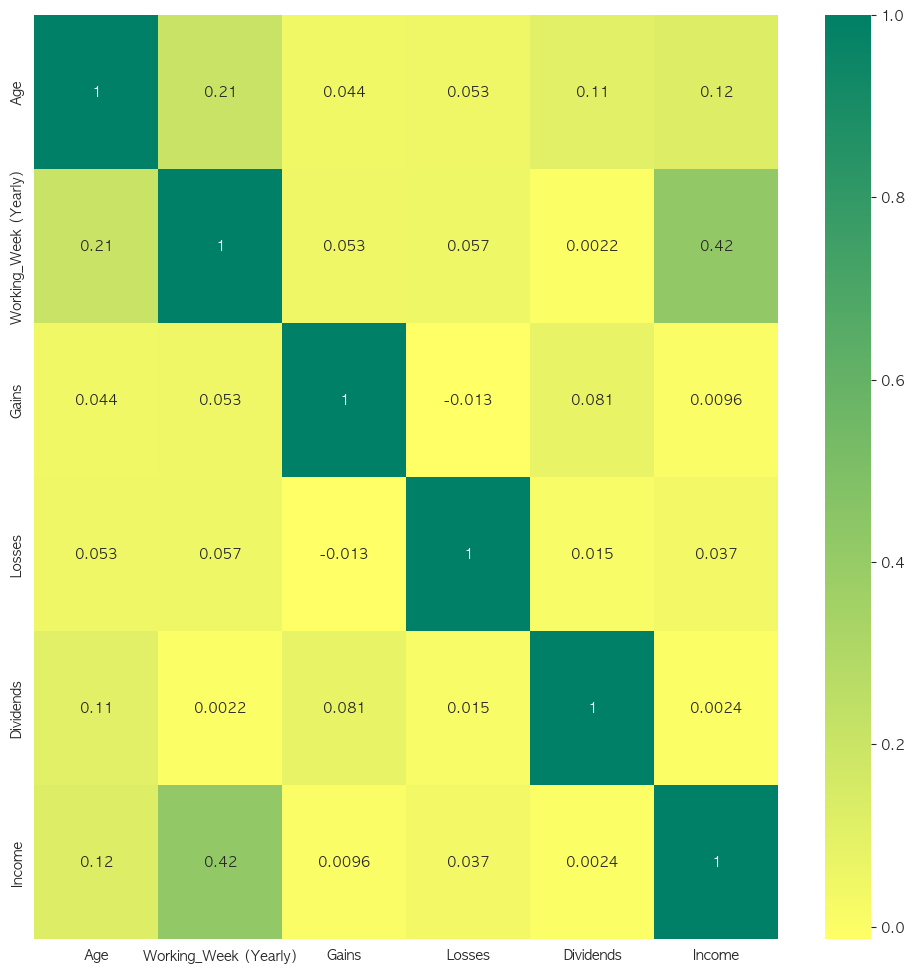

In [329]:
plt.figure(figsize=(12, 12), dpi=100)
sns.heatmap(train_df.corr(), annot=True, cmap="summer_r")
plt.show()

# EDA

In [330]:
train_df.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

## Age

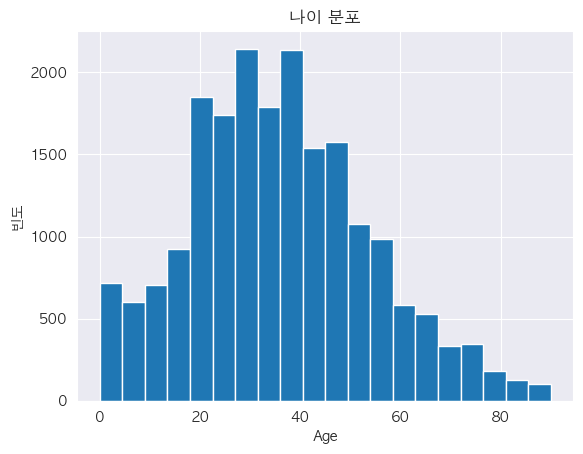

In [331]:
plt.hist(train_df['Age'], bins=20)
plt.xlabel('Age')
plt.ylabel('빈도')
plt.title('나이 분포')
plt.show()

## Gender

In [332]:
gender_counts = train_df.groupby('Gender').size()
gender_counts

Gender
F    10472
M     9528
dtype: int64

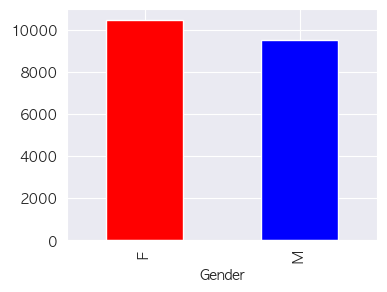

In [333]:
fig, ax = plt.subplots(figsize=(4, 3))
gender_counts.plot(kind='bar', color=['red', 'blue'])
plt.show()

- 특별히 남녀 차이는 보이지 않음. 굳이 나눈다면 결혼 여부에 따라 일을 그만두느냐를 볼 수 있을 것 같은데 결혼 데이터는 해당 데이터셋에 없음.

## Education_Status

In [334]:
education_counts = train_df.groupby('Education_Status').size()
education_counts

Education_Status
Associates degree (Academic)       609
Associates degree (Vocational)     741
Bachelors degree                  1956
Children                          2208
College                           3794
Doctorate degree                    87
Elementary (1-4)                   150
Elementary (5-6)                   317
High Freshman                      555
High Junior                        820
High Senior                        242
High Sophomore                     799
High graduate                     6494
Kindergarten                        64
Masters degree                     505
Middle (7-8)                       548
Professional degree                111
dtype: int64

<Axes: xlabel='Education_Status'>

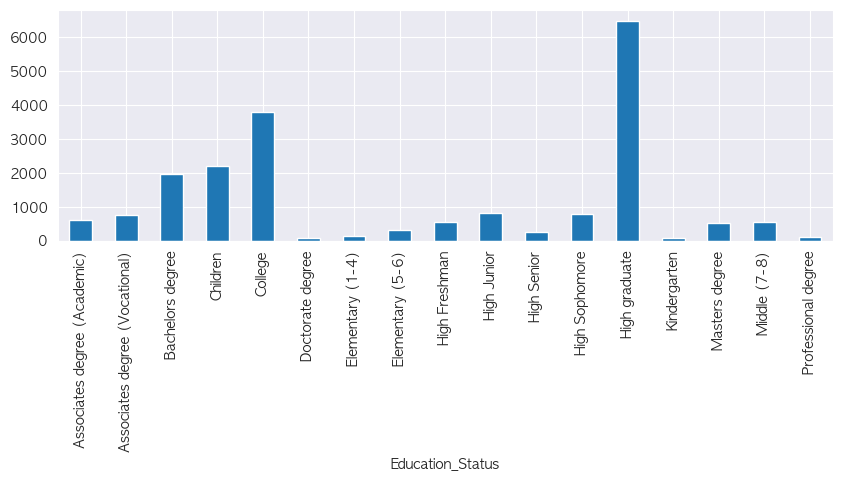

In [335]:
fig, ax = plt.subplots(figsize=(10, 3))
education_counts.plot(kind='bar')

<Axes: xlabel='Education_Status', ylabel='Income'>

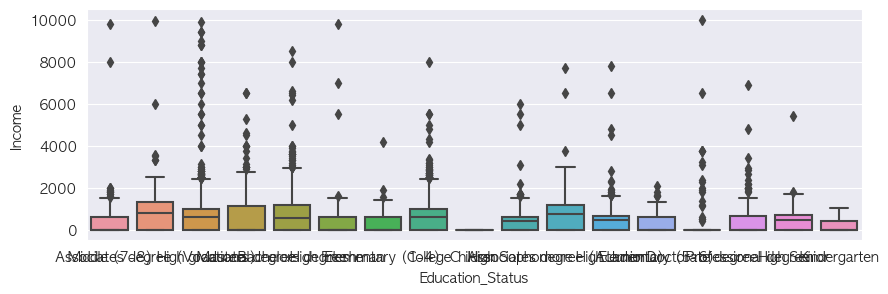

In [336]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(x='Education_Status', y='Income', data=train_df)

- 소득 분석에서는 고졸, 학사, 석사, 박사 수준으로만 구분되는 것이 더 성능이 좋을 것으로 예상

In [337]:
education_counts

Education_Status
Associates degree (Academic)       609
Associates degree (Vocational)     741
Bachelors degree                  1956
Children                          2208
College                           3794
Doctorate degree                    87
Elementary (1-4)                   150
Elementary (5-6)                   317
High Freshman                      555
High Junior                        820
High Senior                        242
High Sophomore                     799
High graduate                     6494
Kindergarten                        64
Masters degree                     505
Middle (7-8)                       548
Professional degree                111
dtype: int64

** 번역
Associates degree (Academic): 학사 학위 (전문)
Associates degree (Vocational): 학사 학위 (전문 직업교육)
Bachelors degree: 학사 학위
Children: 아이들
College: 대학
Doctorate degree: 박사 학위
Elementary (1-4): 초등학교 (1-4학년)
Elementary (5-6): 초등학교 (5-6학년)
High Freshman: 고등학교 신입생
High Junior: 고등학교 3학년생

- 아이들+초딩+고딩, 전문 학사, 전문 직업교육 학사, 학사, 박사 정도?

## Employment_Status

In [338]:
employment_counts = train_df.groupby('Employment_Status').size()
employment_counts

Employment_Status
Children or Armed Forces         11142
Choice Part-Time                   593
Full-Time                         6588
Not Working                       1221
Part-Time (Usually Full-Time)      100
Part-Time (Usually Part-Time)      158
Seeking Full-Time                  121
Seeking Part-Time                   77
dtype: int64

<Axes: xlabel='Employment_Status'>

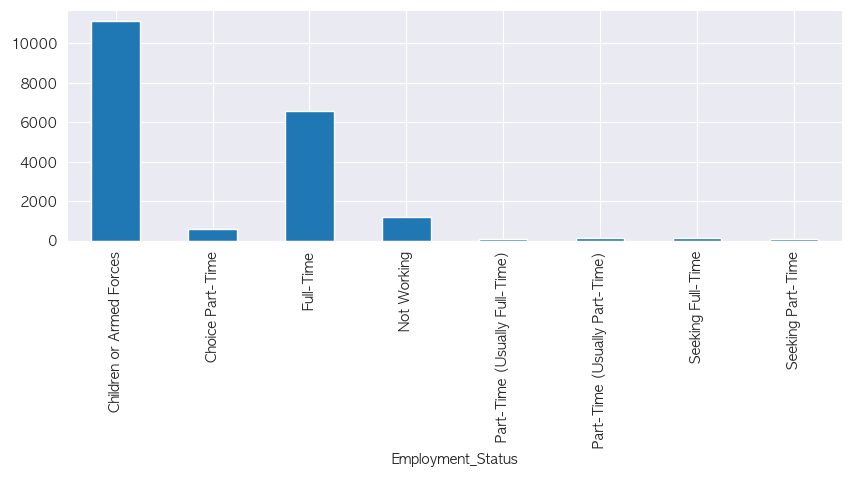

In [339]:
fig, ax = plt.subplots(figsize=(10, 3))
employment_counts.plot(kind='bar')

<Axes: xlabel='Employment_Status', ylabel='Income'>

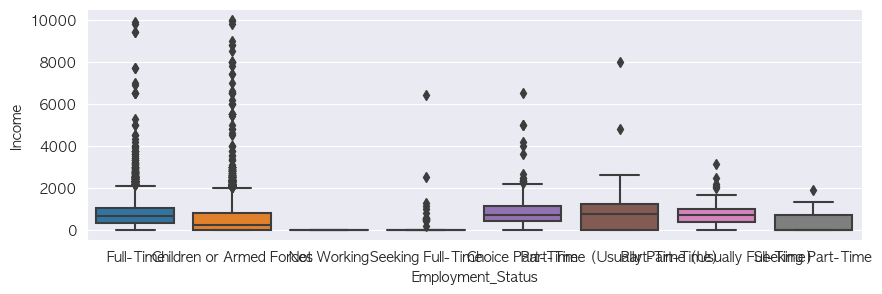

In [340]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(x='Employment_Status', y='Income', data=train_df)

In [341]:
train_df.groupby('Employment_Status')['Income'].mean()

Employment_Status
Children or Armed Forces         488.226979
Choice Part-Time                 792.866779
Full-Time                        746.928051
Not Working                        0.000000
Part-Time (Usually Full-Time)    757.970000
Part-Time (Usually Part-Time)    877.905063
Seeking Full-Time                146.595041
Seeking Part-Time                367.584416
Name: Income, dtype: float64

- Part-Time이라고 해서 딱히 소득 평균이 낮은 건 아님
- Seeking이랑 Part-time만 합치면 되지 않을까 함

## Working_Week (Yearly)

In [342]:
train_df['Working_Week (Yearly)'].describe()

count    20000.000000
mean        34.943050
std         22.254592
min          0.000000
25%          7.000000
50%         52.000000
75%         52.000000
max         52.000000
Name: Working_Week (Yearly), dtype: float64

<Axes: xlabel='Working_Week (Yearly)', ylabel='Income'>

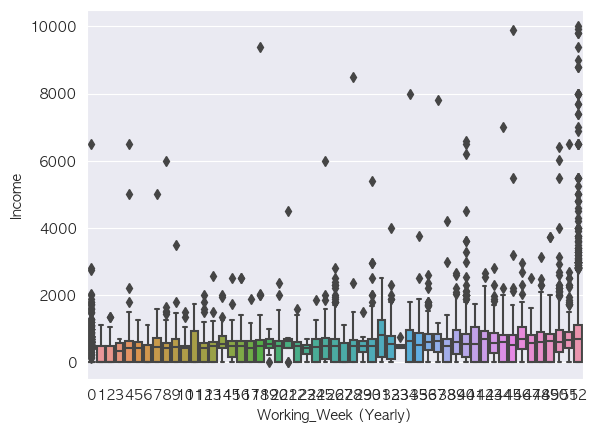

In [343]:
sns.boxplot(x='Working_Week (Yearly)', y='Income', data=train_df)

- 이미 숫자형이고 주당 일한시간은 소득과 선형 상관관계를 가질 것이므로 별도 전처리 필요 없음

## Industry_Status

In [344]:
train_df['Industry_Status']

0                    Social Services
1                      Entertainment
2        Manufacturing (Non-durable)
3                             Retail
4                             Retail
                    ...             
19995        Manufacturing (Durable)
19996                      Education
19997                 Transportation
19998    Not in universe or children
19999          Public Administration
Name: Industry_Status, Length: 20000, dtype: object

In [345]:
train_df.groupby('Industry_Status')['Income'].mean()

Industry_Status
Agriculture                                      434.630597
Armed Forces                                       0.000000
Business & Repair                                646.846517
Communications                                   952.835897
Construction                                     887.155048
Education                                        616.393852
Entertainment                                    703.643885
Finance Insurance & Real Estate                  625.617607
Forestry & Fisheries                             592.038462
Hospitals                                       1040.193666
Manufacturing (Durable)                          907.412063
Manufacturing (Non-durable)                      739.130826
Medical (except Hospitals)                       718.083532
Mining                                           975.700935
Not in universe or children                        0.000000
Other professional services                      747.366876
Personal Services (excep

- 산업 구분은 그냥 전처리만 해주면 될 듯 함.

## Occupation_Status

In [346]:
train_df['Occupation_Status']

0                                Services
1                                Services
2        Admin Support (include Clerical)
3                   Technicians & Support
4                                   Sales
                       ...               
19995                   Handlers/Cleaners
19996    Admin Support (include Clerical)
19997               Technicians & Support
19998                             Unknown
19999    Admin Support (include Clerical)
Name: Occupation_Status, Length: 20000, dtype: object

In [347]:
train_df.groupby('Occupation_Status')['Income'].mean()

Occupation_Status
Admin Support (include Clerical)     750.374677
Armed Forces                           0.000000
Craft & Repair                       986.415730
Farming & Forestry & Fishing         477.922297
Handlers/Cleaners                    655.152927
Machine Operators & Inspectors       802.055676
Management                           619.179118
Private Household Services           420.857143
Professional                         884.705645
Protective Services                  823.511538
Sales                                488.010638
Services                             512.062257
Technicians & Support               1002.417563
Transportation                       846.002899
Unknown                                0.000000
Name: Income, dtype: float64

## Race

In [348]:
train_df['Race'].unique()

array(['White', 'Black', 'Native American/Aleut/Eskimo', 'Asian/Pacific',
       'Other'], dtype=object)

In [349]:
train_df.groupby('Race')['ID'].count()

Race
Asian/Pacific                     511
Black                            2122
Native American/Aleut/Eskimo      226
Other                             296
White                           16845
Name: ID, dtype: int64

## Hispanic_Origin

In [350]:
train_df.groupby('Hispanic_Origin')['ID'].count()

Hispanic_Origin
 All other                    17769
 Central or South American      325
 Chicano                         27
 Cuban                           76
 Do not know                     22
 Mexican (Mexicano)             624
 Mexican-American               654
 NA                              59
 Other Spanish                  201
 Puerto Rican                   243
Name: ID, dtype: int64

- 그냥 Race만 구분하면 될 것 같은데, 굳이 hispac까지 세부적으로 구분하는 게 성능이 좋은지 feature_importance 확인 필요 

## Martial_Status

In [351]:
train_df.groupby('Martial_Status')['ID'].count()

Martial_Status
Divorced                        1633
Married                         9554
Married (Armed Force Spouse)      70
Married (Spouse Absent)          171
Separated                        436
Single                          7380
Widowed                          756
Name: ID, dtype: int64

## Household_Status

In [352]:
train_df.groupby('Household_Status')['ID'].count()


Household_Status
Child 18+ ever marr Not in a subfamily                                     118
Child 18+ ever married Responsible Person of subfamily                     101
Child 18+ never marr Not in a subfamily                                   1860
Child 18+ never married Responsible Person of subfamily                     96
Child 18+ spouse of subfamily Responsible Person                            16
Child <18 ever marr not in subfamily                                         3
Child <18 ever married Responsible Person of subfamily                       1
Child <18 never marr not in subfamily                                     2670
Child <18 never married Responsible Person of subfamily                      8
Child under 18 of Responsible Person of unrelated subfamily                 39
Grandchild 18+ ever marr not in subfamily                                    3
Grandchild 18+ ever married Responsible Person of subfamily                  1
Grandchild 18+ never marr not in su

- 부양가족이 있는 경우 소득이 더 높은 것은 아니지만, 소득이 '더 높아야 하기 때문에' 상관관계가 있을 것으로 추정

## Household_Summary

In [353]:
train_df.groupby('Household_Summary')['ID'].count()

Household_Summary
Child 18 or older                       2192
Child under 18 ever married                4
Child under 18 never married            2679
Group Quarters- Secondary individual      24
Householder                             8552
Nonrelative of householder               974
Other relative of householder            781
Spouse of householder                   4794
Name: ID, dtype: int64

## Citizenship

In [354]:
train_df.groupby('Citizenship')['ID'].count()


Citizenship
Foreign-born (Naturalized US Citizen)            588
Foreign-born (Non-US Citizen)                   1258
Native                                         17825
Native (Born Abroad)                             197
Native (Born in Puerto Rico or US Outlying)      132
Name: ID, dtype: int64

## Birth_Country

In [355]:
train_df.groupby('Birth_Country')['ID'].count()

Birth_Country
Cambodia                            8
Canada                             75
China                              28
Columbia                           36
Cuba                               58
Dominican-Republic                 49
Ecuador                            31
El-Salvador                        68
England                            47
France                             14
Germany                            90
Greece                             13
Guatemala                          28
Haiti                              25
Holand-Netherlands                  3
Honduras                           14
Hong Kong                          16
Hungary                             4
India                              55
Iran                               24
Ireland                            21
Italy                              35
Jamaica                            45
Japan                              30
Laos                               11
Mexico                            54

- 선진국과 후진국 정도로 나누면 되지 않을지..?

## Birth_Country (Father) 

In [356]:
train_df.groupby('Birth_Country (Father)')['ID'].count()

Birth_Country (Father)
Cambodia                           13
Canada                            128
China                              69
Columbia                           45
Cuba                               78
Dominican-Republic                 99
Ecuador                            42
El-Salvador                        83
England                            69
France                             17
Germany                            92
Greece                             33
Guatemala                          33
Haiti                              37
Holand-Netherlands                  5
Honduras                           12
Hong Kong                           8
Hungary                            22
India                              68
Iran                               25
Ireland                            47
Italy                             197
Jamaica                            56
Japan                              28
Laos                               12
Mexico                     

## Birth_Country (Mother)

In [357]:
train_df.groupby('Birth_Country (Mother)')['ID'].count()

Birth_Country (Mother)
Cambodia                           11
Canada                            159
China                              60
Columbia                           45
Cuba                               73
Dominican-Republic                 75
Ecuador                            44
El-Salvador                        99
England                            88
France                             25
Germany                           117
Greece                             23
Guatemala                          36
Haiti                              34
Holand-Netherlands                  4
Honduras                           17
Hong Kong                          10
Hungary                            18
India                              67
Iran                               26
Ireland                            58
Italy                             152
Jamaica                            56
Japan                              37
Laos                                8
Mexico                     

- 결국 이 엄마아빠의 국적 데이터는 그냥 국적 데이터랑 연결이 되어 있을 것임

## Tax_Status

In [358]:
train_df.groupby('Tax_Status')['ID'].count()

Tax_Status
Head of Household (HOH)                                     1217
Married Filling Jointly both over 65 (MFJ)                   469
Married Filling Jointly both under 65 (MFJ)                 8588
Married Filling Jointly one over 65 & one under 65 (MFJ)     305
Nonfiler                                                    3874
Single                                                      5547
Name: ID, dtype: int64

## Gains

In [359]:
train_df.groupby('Gains')['ID'].count()

Gains
0        19217
114          4
401          2
594          7
914          5
         ...  
18481        1
20051        9
25124        3
27828        7
99999       30
Name: ID, Length: 106, dtype: int64

In [360]:
train_df['Gains'].describe()

count    20000.000000
mean       383.129500
std       4144.247487
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: Gains, dtype: float64

## Losses

In [361]:
train_df.groupby('Losses')['ID'].count()

Losses
0       19568
155         1
213         6
323         3
419         1
        ...  
2824        1
3175        1
3770        1
3900        1
4356        2
Name: ID, Length: 86, dtype: int64

In [362]:
train_df['Losses'].describe()

count    20000.000000
mean        40.202150
std        279.182677
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: Losses, dtype: float64

In [363]:
## Dividends

In [364]:
## Income_Status

In [365]:
## Income

# Feature Engineering

1. Age : 처리 없음
2. Gender : M, F One-hot Encoding
3. Education_Status : children+Elementary (1-4)+Elementary (5-6)+High Freshman+High Junior, 나머지 그대로, Labelencoder
4. Employment_Status : 일단 그대로 돌려보고 Seeking 2r개 합치거나, Part-Time 2개 합치는 방향으로, OHE
5. Working_Week (Yearly) : 그대로
6. Industry_Status : OHE
7. Occupation_Status : OHE
8. Race : OHE
9. Hispanic_Origin : 돌려보고 아예 변수 삭제, OHE
10. Martial_Status : Armed Force Spouse는 Married로, Spouse Absent는 Widowed로 합치는 것을 검토, 우선 그냥 학습, OHE
11. Household_Status : 일단 그대로, OHE
12. Household_Summary : 일단 그대로, OHE
13. Citizenship : 일단 그대로, OHE
14. Birth_Country :  일단 그대로, OHE
15. Birth_Country (Father) : Feature Importance 보고 삭제
16. Birth_Country (Mother) : Feature Importance 보고 삭제
17. Tax_Status : OHE
18. Gains, Losses, Dividends : 처리 없음
19. Income_Status : OHE

#### Feature Engineering : Investment Income Ratio (투자 수익률)

In [366]:
investment_ratio = train_df[['Gains','Losses','Dividends','Income']].copy()
investment_ratio

,Gains,Losses,Dividends,Income
0,0,0,0,425
1,0,0,0,0
2,3411,0,0,860
3,0,0,0,850
4,0,0,0,570
...,...,...,...,...
19995,0,0,0,1300
19996,0,0,0,850
19997,0,0,0,999
19998,0,0,0,0


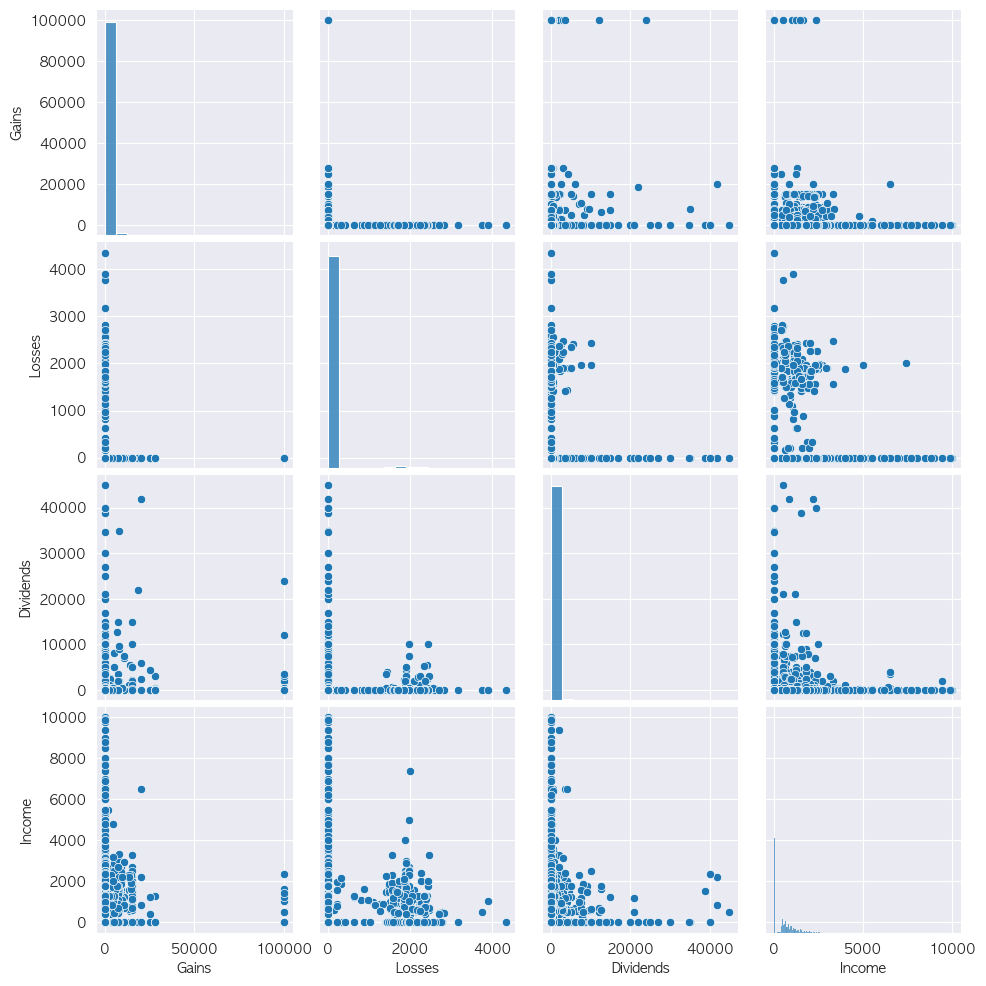

In [367]:
# fig, ax = plt.subplots(figsize=(5, 5))
sns.pairplot(investment_ratio)

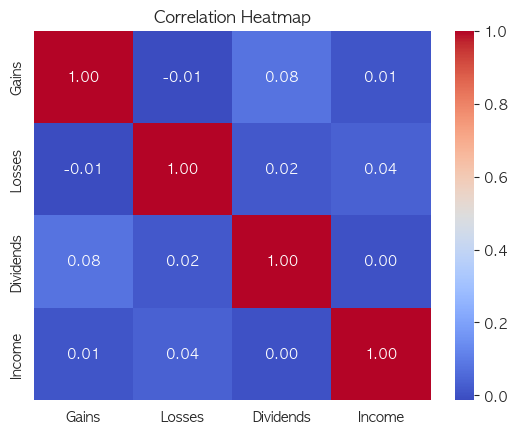

In [368]:
# 상관 관계 히트맵(Heatmap) 시각화
correlation_matrix = investment_ratio[['Gains', 'Losses', 'Dividends', 'Income']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [369]:
# investment_ratio = (Gains+Dividends-Losses)/Income 
# train_df 데이터프레임에 investment_ratio 컬럼 추가
train_df['investment_amount'] = (train_df['Gains'] + train_df['Dividends'] - train_df['Losses'])
test_df['investment_amount'] = (test_df['Gains'] + test_df['Dividends'] - test_df['Losses'])

#### Feature Engineering : Age binning


In [370]:
# # Age를 10살 단위로 묶기
# age_bins = list(range(0, 101, 5))  # 0부터 100까지 10씩 증가하는 구간
# age_labels = ['{}-{}'.format(start, end) for start, end in zip(age_bins[:-1], age_bins[1:])]  # 레이블 생성
# 
# # pd.cut(x, bins, labels=None, right=True, include_lowest=False, ...)
# train_df['Age_Group'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=False).astype('object')
# test_df['Age_Group'] = pd.cut(test_df['Age'], bins=age_bins, labels=age_labels, right=False).astype('object')

# 데이터 전처리 : 컬럼 삭제

In [371]:
train_df = train_df.drop(columns=['Birth_Country (Father)','Birth_Country (Mother)','Gains','Losses','Dividends'], axis=1)
test_df = test_df.drop(columns=['Birth_Country (Father)','Birth_Country (Mother)','Gains','Losses','Dividends'], axis=1)

In [372]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     20000 non-null  object
 1   Age                    20000 non-null  int64 
 2   Gender                 20000 non-null  object
 3   Education_Status       20000 non-null  object
 4   Employment_Status      20000 non-null  object
 5   Working_Week (Yearly)  20000 non-null  int64 
 6   Industry_Status        20000 non-null  object
 7   Occupation_Status      20000 non-null  object
 8   Race                   20000 non-null  object
 9   Hispanic_Origin        20000 non-null  object
 10  Martial_Status         20000 non-null  object
 11  Household_Status       20000 non-null  object
 12  Household_Summary      20000 non-null  object
 13  Citizenship            20000 non-null  object
 14  Birth_Country          20000 non-null  object
 15  Tax_Status         

# 학습 및 추론 데이터 설정

In [373]:
# 훈련 데이터를 훈련 세트와 검증 세트로 나눔
train_x, val_x, train_y, val_y = train_test_split(train_df.drop(columns=['ID', 'Income']), 
                                                  train_df['Income'], 
                                                  test_size=0.2, 
                                                  random_state=42)
test_x = test_df.drop(columns=['ID'])

In [374]:
# OneHotEncoder 객체 생성
encoder = OneHotEncoder()

In [375]:
encoding_target = pd.DataFrame(train_x[train_x.select_dtypes(include=['object']).columns])
encoding_target

,Gender,Education_Status,Employment_Status,Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,Household_Status,Household_Summary,Citizenship,Birth_Country,Tax_Status,Income_Status
5894,F,College,Not Working,Not in universe or children,Unknown,Other,Mexican (Mexicano),Single,Other Rel 18+ never marr not in subfamily,Other relative of householder,Foreign-born (Non-US Citizen),Mexico,Nonfiler,Under Median
3728,F,High graduate,Full-Time,Retail,Handlers/Cleaners,Black,All other,Married,Spouse of householder,Spouse of householder,Native,US,Married Filling Jointly both under 65 (MFJ),Under Median
8958,F,High graduate,Full-Time,Hospitals,Technicians & Support,White,All other,Married,Householder,Householder,Native,US,Married Filling Jointly both under 65 (MFJ),Under Median
7671,F,High graduate,Children or Armed Forces,Retail,Sales,White,All other,Single,Child 18+ never marr Not in a subfamily,Child 18 or older,Native,US,Single,Under Median
5999,M,Masters degree,Children or Armed Forces,Public Administration,Professional,White,All other,Married,Householder,Householder,Native (Born Abroad),Haiti,Married Filling Jointly both under 65 (MFJ),Over Median
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,F,High graduate,Not Working,Not in universe or children,Unknown,White,All other,Married,Spouse of householder,Spouse of householder,Native,US,Married Filling Jointly both over 65 (MFJ),Under Median
11964,F,Children,Children or Armed Forces,Not in universe or children,Unknown,Asian/Pacific,Central or South American,Single,Child <18 never marr not in subfamily,Child under 18 never married,Native,US,Nonfiler,Unknown
5390,F,Children,Children or Armed Forces,Not in universe or children,Unknown,White,All other,Single,Child <18 never marr not in subfamily,Child under 18 never married,Native,US,Nonfiler,Unknown
860,F,High Freshman,Children or Armed Forces,Retail,Services,White,All other,Single,Householder,Householder,Native,US,Head of Household (HOH),Under Median


In [376]:
# train, val
for i in encoding_target:
    le = OneHotEncoder()
        
    le.fit(train_x[i].values.reshape(-1, 1))  # train_x[i]를 2차원 배열로 변환하여 fit 메서드에 전달
    train_x[i] = le.transform(train_x[i].values.reshape(-1, 1)).toarray()  # 희소 행렬을 밀집 행렬로 변환한 후 DataFrame의 열에 할당
    
    # test 데이터에서 나올 수 있는 새로운 카테고리에 대해 categories_ 배열에 추가
    for case in np.unique(val_x[i]):
        if case not in le.categories_[0]: 
            le.categories_ = [np.append(le.categories_[0], case)]
    
    val_x[i] = le.transform(val_x[i].values.reshape(-1, 1)).toarray()  # 희소 행렬을 밀집 행렬로 변환한 후 DataFrame의 열에 할당

In [377]:
# test
for i in encoding_target:
    le = OneHotEncoder()
        
    le.fit(test_x[i].values.reshape(-1, 1))  # train_x[i]를 2차원 배열로 변환하여 fit 메서드에 전달
    test_x[i] = le.transform(test_x[i].values.reshape(-1, 1)).toarray()  # 희소 행렬을 밀집 행렬로 변환한 후 DataFrame의 열에 할당

# 모델링

In [402]:
xgb_model = xgb.XGBRegressor(
    n_estimators=70,  # 트리 개수
    learning_rate=0.2,  # 학습률
    max_depth=3,  # 트리 최대 깊이
    subsample=0.8,  # 각 트리를 학습할 때 사용할 샘플의 비율
    colsample_bytree=0.8,  # 각 트리를 학습할 때 사용할 feature의 비율
    reg_alpha=0,  # L1 정규화 항 (alpha)
    reg_lambda=1,  # L2 정규화 항 (lambda)
    random_state=42  # 랜덤 시드
)

xgb_model.fit(train_x, train_y)

# 검증 세트로 모델 평가
val_predictions = xgb_model.predict(val_x)
rmse = np.sqrt(mean_squared_error(val_y, val_predictions))
r_squared = r2_score(val_y, val_predictions)
print("Validation RMSE:", rmse)
print("Validation R-squared:", r_squared)

Validation RMSE: 619.4416895609216
Validation R-squared: 0.22061969477377863


# 최종 예측

In [379]:
preds = xgb_model.predict(test_x)

# 제출자료 생성

In [380]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Income'] = preds
submission

,ID,Income
0,TEST_0000,19.436153
1,TEST_0001,208.107544
2,TEST_0002,462.429871
3,TEST_0003,631.455078
4,TEST_0004,1.671261
...,...,...
9995,TEST_9995,836.419861
9996,TEST_9996,794.162170
9997,TEST_9997,353.064697
9998,TEST_9998,28.437109


In [381]:
current_datetime = datetime.datetime.now()
file_name = f'submission_{current_datetime.strftime("%Y%m%d_%H%M")}.csv'

In [382]:
submission.to_csv('result/'+file_name, index=False)